In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import numpy as np
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.mueller import Mueller

from py_pol import degrees

import matplotlib.pyplot as plt

from py_aocg.SLM_system import cargar_Jones_SLM, SLM_system_field
from py_aocg.ifta.algorithms import distances_scalar

In [69]:
np.set_printoptions(precision=10)

In [70]:
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

## Cargar Matrices de polarización de Holoeye

In [109]:
S_incident=Jones_vector('incident')
S_incident.circular_light(intensity=2)

Jslm=cargar_Jones_SLM(type="Jones",filename='SLM_Jones_components.npz')

In [110]:
size_x_DOE, size_y_DOE = 15,15
doe_real = np.linspace(-1,1, size_x_DOE)
doe_imag = np.linspace(-1,1, size_y_DOE)

DOE_real, DOE_imag = np.meshgrid(doe_real, doe_imag)

DOE = DOE_real + 1j*DOE_imag

In [111]:
def cost_function_distances(angles, Jslm, S_incident):
    """ Cost function to obtain a properly SLM phase configuration 
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        S_incident (Jones_vector): Illumination
        
    Returns:
        cost: (float): Value of merit function of a SLM phase configuration
        
    """

    u_fab_amplitude, u_fab_phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

    # Normalizar
    # u_fab_amplitude = u_fab_amplitude / u_fab_amplitude.max()
    u_fab = u_fab_amplitude*np.exp(1j*u_fab_phase)
    u_fab_real =u_fab[::5].real
    u_fab_imag =u_fab[::5].imag
    
    DOE_new, i_positions, distances=distances_scalar(DOE, u_fab)
    
    cost = distances.mean()
    # cost = np.linalg.norm(distances)
    
    return cost

In [112]:
def optimization_loop(angles,Jslm, S_incident, optimize_function):
    """
    Optimization loop of the particules of PySwarms algorithm.
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        optimize_function (function): Function to optimize.
    
    Returns:
        cost: (float): Value of merit function
    
    """
    num_particles = angles.shape[0]
    cost = [cost_function_distances(angles[i,:],Jslm, S_incident) for i in range(num_particles)]
    
    return cost

In [113]:
Jslm = cargar_Jones_SLM()
print(Jslm.shape)

[256]


In [114]:
options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
# options = {'c1': 0.5, 'c2': 0.5, 'w': 0.5}
dimensions = 4
min_bound = np.zeros(dimensions); max_bound = np.ones(dimensions)*360*degrees
bounds = (min_bound, max_bound)

iters=50
n_particles=80

In [155]:
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

In [156]:
%%time 
cost, angles = optimizer.optimize(optimization_loop,iters,Jslm=Jslm, S_incident=S_incident ,optimize_function=cost_function_distances)

2023-01-30 13:40:07,447 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.207
2023-01-30 13:40:35,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.20702455818128418, best pos: [2.5092750652 0.4989919052 2.6263181151 4.5590237447]


CPU times: total: 27.7 s
Wall time: 28.1 s


In [149]:
#angles = np.array([1.61038889, 1.947723,   2.66072842, 4.8141105])
print(angles)


[1.61038889 1.947723   2.66072842 4.8141105 ]


- best cost: 0.21199592361665928, best pos: [1.63644037 5.11863528 2.7111866  1.68529409]
- best cost: 0.21164481754171188, best pos: [1.61038889 1.947723   2.66072842 4.8141105 ]

In [157]:
 u_fab_amplitude, u_fab_phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

In [158]:
# Normalizar
# u_fab_amplitude = u_fab_amplitude / u_fab_amplitude.max()
u_fab = u_fab_amplitude*np.exp(1j*u_fab_phase)
u_fab_real =u_fab[::5].real
u_fab_imag =u_fab[::5].imag

DOE_new, i_positions, distances=distances_scalar(DOE, u_fab)

In [159]:
print(i_positions)

[[120 120 118 109 112 100  83  79  67  67  60  60 255 255 255]
 [134 129 120 117  91  90  82  70  67  66  60  60 255 255 255]
 [138 134 129 127  91  78  68  62  55  58  60  60 255 255 255]
 [148 144 146 135 125  78  62  55  54  51  48 255 255 255 255]
 [159 160 165 165 165  91  55  52  50  47  44  45 255 255 255]
 [168 171 175 176 176 165  55  49  47  43  42  41  41 255 255]
 [174 189 181 181 181 181  35  35  39  38  38  38  38 254 254]
 [191 198 198 198 198 206  18  26  29   0   0  36  36 254 254]
 [202 206 208 214 216 225  18  18  25  26  30  33 254 254 254]
 [210 216 218 225 221 228   1  18  18  25  26  28 253 254 254]
 [219 225 224 222 228 227   1   1   1   2  10 253 253 253 253]
 [220 220 222 228 227 238 244   1   1   1 251 251 253 253 253]
 [220 229 232 234 236 240 244 243 248 249 250 251 251 253 253]
 [229 232 239 239 242 240 244 243 248 249 250 252 251 251 253]
 [232 239 239 242 242 244 245 247 248 249 249 252 251 251 251]]


In [160]:
print(distances)

0.20702455818128418


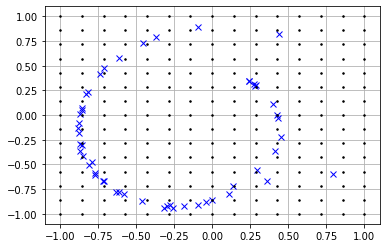

In [161]:
plt.figure()
plt.plot(u_fab_real, u_fab_imag, 'bx', ms=6)
plt.plot(DOE_real, DOE_imag, 'k.', ms=3)
plt.grid(True)